<a href="https://colab.research.google.com/github/uday-routhu/week7/blob/master/Neural_Networks_Core.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Neural Networks (Core)

- author: Udayakumar Routhu

Required Task:
1. Be sure to perform a train test split on the train.csv so you can evaluate your models.
2. Create and evaluate 3 iterations of a deep learning model to predict housing prices using the techniques you have learned to optimize your model's performance.
3. Be sure to include some form of regularization with at least one model.
Select your best model!

1. What am I predicting?
   - Natural Language Processing with Disaster Tweets
Predict which Tweets are about real disasters and which ones are not
  - predicting whether a given tweet is about a real disaster or not. If so, predict a 1. If not, predict a 0.

### Source of data
  The data can be downloaded from [this link](https://www.kaggle.com/competitions/house-prices-advanced-regression-techniques/data?select=sample_submission.csv)

### Import Libraries

In [121]:
# imports
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_selector, ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow import keras
from keras.layers import Dense
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, \
classification_report, ConfusionMatrixDisplay

# new libraries
import tensorflow as tf
import tensorflow.keras as keras
from keras.models import Sequential
from keras.layers import Dense, Dropout
from tensorflow.keras.metrics import RootMeanSquaredError
# Set global scikit-learn configuration
from sklearn import set_config
# Display estimators as a diagram
set_config(display='diagram') # 'text' or 'diagram'}

In [72]:
def eval_regression(model, X, y, name='model'):
    """Returns a dataframe with regression metrics.
    optional name variable can be used to name each model and/or dataset used
    for clarity"""
    score_df = pd.DataFrame(index=[name])
    preds = model.predict(X)
    score_df.loc[name,'MAE'] = mean_absolute_error(y, preds)
    score_df.loc[name,'RMSE'] = np.sqrt(mean_squared_error(y, preds))
    score_df.loc[name,'R2'] = r2_score(y, preds)
    return score_df

def plot_history(history):
  """Takes a keras model learning history and plots each metric"""

  metrics = history.history.keys()

  for metric in metrics:
      if not 'val' in metric:
        plt.plot(history.history[f'{metric}'], label=f'{metric}')
        if f'val_{metric}' in metrics:
          plt.plot(history.history[f'val_{metric}'], label=f'val_{metric}')
        plt.legend()
        plt.title(f'{metric}')
        plt.show()

In [73]:
def plot_history(history, figsize=(6,12), marker='o'):

    # Get list of metrics from history
    metrics = [c for c in history.history if not c.startswith('val_')]

    ## Separate row for each metric
    fig, axes = plt.subplots(nrows=len(metrics),figsize=figsize)

    # For each metric
    for i, metric_name in enumerate(metrics):

        # Get the axis for the current metric
        ax = axes[i]

        # Get metric from history.history
        metric_values = history.history[metric_name]
        # Get epochs from history
        epochs = history.epoch

        # Plot the training metric
        ax.plot(epochs, metric_values, label=metric_name, marker=marker)

        ## Check if val_{metric} exists. if so, plot:
        val_metric_name = f"val_{metric_name}"
        if val_metric_name in history.history:
            # Get validation values and plot
            metric_values = history.history[val_metric_name]
            ax.plot(epochs,metric_values,label=val_metric_name, marker=marker)

        # Final subplot adjustments
        ax.legend()
        ax.set_title(metric_name)
    fig.tight_layout()

    return fig, axes

In [3]:
# Mount google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [76]:
# Load in the dataset from url
fpath = "/content/drive/MyDrive/CodingDojo/03-AdvancedML/Week09/Data/train.csv"
df = pd.read_csv(fpath, index_col=0)
df.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
Id,,,,,,,,,,,,,,,,,,,,,
1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [52]:
# Display the number of rows and columns for the dataframe
df.shape
print(f'There are {df.shape[0]} rows, and {df.shape[1]} columns.')
print(f'The rows represent {df.shape[0]} observations, and the columns represent {df.shape[1]-1} features and 1 target variable.')

There are 1460 rows, and 80 columns.
The rows represent 1460 observations, and the columns represent 79 features and 1 target variable.


In [51]:
# count rows with missing values
na_rows = df.isna().any(axis=1).sum()

print(f'{na_rows} rows are missing data')
print(f'{na_rows/len(df)*100:.1f}% of rows are missing data')

1460 rows are missing data
100.0% of rows are missing data


## Prepare the Data

In [40]:
# Display the info for the dataframe
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1460 entries, 1 to 1460
Data columns (total 80 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   MSSubClass     1460 non-null   int64  
 1   MSZoning       1460 non-null   object 
 2   LotFrontage    1201 non-null   float64
 3   LotArea        1460 non-null   int64  
 4   Street         1460 non-null   object 
 5   Alley          91 non-null     object 
 6   LotShape       1460 non-null   object 
 7   LandContour    1460 non-null   object 
 8   Utilities      1460 non-null   object 
 9   LotConfig      1460 non-null   object 
 10  LandSlope      1460 non-null   object 
 11  Neighborhood   1460 non-null   object 
 12  Condition1     1460 non-null   object 
 13  Condition2     1460 non-null   object 
 14  BldgType       1460 non-null   object 
 15  HouseStyle     1460 non-null   object 
 16  OverallQual    1460 non-null   int64  
 17  OverallCond    1460 non-null   int64  
 18  YearBuil

In [91]:
df.isna().sum()

MSSubClass         0
MSZoning           0
LotFrontage      259
LotArea            0
Street             0
                ... 
MoSold             0
YrSold             0
SaleType           0
SaleCondition      0
SalePrice          0
Length: 80, dtype: int64

In [92]:
# check for duplicates
df.duplicated().sum()

0

In [93]:
df = df.drop_duplicates()

In [94]:
#check for duplicates
df.duplicated().sum()

0

In [95]:
df['SalePrice'].value_counts()

140000    20
135000    17
155000    14
145000    14
190000    13
          ..
202665     1
164900     1
208300     1
181500     1
147500     1
Name: SalePrice, Length: 663, dtype: int64

In [104]:
# Save X data
X = df.drop('SalePrice', axis=1)  # Features
# Encode our target
y = df['SalePrice']

In [97]:
df.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
Id,,,,,,,,,,,,,,,,,,,,,
1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [132]:
df.describe()

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
count,1460.000000,1201.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1452.000000,1460.000000,1460.000000,...,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000
mean,56.897260,70.049958,10516.828082,6.099315,5.575342,1971.267808,1984.865753,103.685262,443.639726,46.549315,...,94.244521,46.660274,21.954110,3.409589,15.060959,2.758904,43.489041,6.321918,2007.815753,180921.195890
std,42.300571,24.284752,9981.264932,1.382997,1.112799,30.202904,20.645407,181.066207,456.098091,161.319273,...,125.338794,66.256028,61.119149,29.317331,55.757415,40.177307,496.123024,2.703626,1.328095,79442.502883
min,20.000000,21.000000,1300.000000,1.000000,1.000000,1872.000000,1950.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000,34900.000000
25%,20.000000,59.000000,7553.500000,5.000000,5.000000,1954.000000,1967.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,2007.000000,129975.000000
50%,50.000000,69.000000,9478.500000,6.000000,5.000000,1973.000000,1994.000000,0.000000,383.500000,0.000000,...,0.000000,25.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000,163000.000000
75%,70.000000,80.000000,11601.500000,7.000000,6.000000,2000.000000,2004.000000,166.000000,712.250000,0.000000,...,168.000000,68.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000,214000.000000
max,190.000000,313.000000,215245.000000,10.000000,9.000000,2010.000000,2010.000000,1600.000000,5644.000000,1474.000000,...,857.000000,547.000000,552.000000,508.000000,480.000000,738.000000,15500.000000,12.000000,2010.000000,755000.000000


## Train/Test Split

In [102]:
# Split the data (random_state=42 for reproducibility)
X_train, X_test, y_train, y_test = train_test_split(X,y, random_state = 42)

In [103]:
# Check class balance
y_train.value_counts(normalize=True)

140000    0.012785
135000    0.011872
110000    0.010959
190000    0.010959
155000    0.010046
            ...   
133500    0.000913
424870    0.000913
252000    0.000913
179600    0.000913
189950    0.000913
Name: SalePrice, Length: 548, dtype: float64

### Transformer

In [105]:
# Categorical Preprocessing Pipeline
# Save list of column names
ohe_cols = X_train.select_dtypes('object').columns
print("OneHotEncoder Columns:", ohe_cols)
# Instantiate the individual preprocessors
impute_na = SimpleImputer(strategy='constant', fill_value = "Missing")
ohe_encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
# Make pipeline with imputer and encoder
ohe_pipe = make_pipeline(impute_na, ohe_encoder)
# Making a ohe_tuple for ColumnTransformer
ohe_tuple = ('categorical', ohe_pipe, ohe_cols)
# Numerical Preprocessing Pipeline
# Save list of column names
num_cols = X_train.select_dtypes("number").columns
print("Numeric Columns:", num_cols)
# instantiate preprocessors
impute_median = SimpleImputer(strategy='median')
scaler = StandardScaler()
# Make a numeric preprocessing pipeline
num_pipe = make_pipeline(impute_median, scaler)
# Making a numeric tuple for ColumnTransformer
num_tuple = ('numeric', num_pipe, num_cols)
# Create the Column Transformer
preprocessor = ColumnTransformer([num_tuple, ohe_tuple],
                                 verbose_feature_names_out=False)

OneHotEncoder Columns: Index(['MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities',
       'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2',
       'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st',
       'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation',
       'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2',
       'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual',
       'Functional', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual',
       'GarageCond', 'PavedDrive', 'PoolQC', 'Fence', 'MiscFeature',
       'SaleType', 'SaleCondition'],
      dtype='object')
Numeric Columns: Index(['MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond',
       'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2',
       'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF',
       'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', '

In [100]:
# process the data
X_train_processed = preprocessor.fit_transform(X_train)
X_test_processed = preprocessor.transform(X_test)

# Model 1

In [113]:
# Reset Random seed for consistency
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)
# use all features as input using input_dim
input_dim = X_train_processed.shape[1]

# Instantiate your sequential model
import numpy as np
model1 = Sequential()

# Add first hidden layer
model1.add(Dense(3, activation= 'relu', input_dim = input_dim, name ='h1'))
model1.add(Dense(6, activation='relu', name='h2')) # Added an extra hidden layer with ReLU activation
model1.add(Dense(1, activation='sigmoid'))  #Output layer remains the same for binary classification

# Add output layer with 1 node
model1.add(Dense(1, activation = 'linear', name = 'output'))

# Check summary of network
model1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 h1 (Dense)                  (None, 3)                 903       
                                                                 
 h2 (Dense)                  (None, 6)                 24        
                                                                 
 dense (Dense)               (None, 1)                 7         
                                                                 
 output (Dense)              (None, 1)                 2         
                                                                 
Total params: 936 (3.66 KB)
Trainable params: 936 (3.66 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [114]:
# Compile your model.
rmse = RootMeanSquaredError(name='rmse')
model1.compile(optimizer= 'adam', loss = 'mse', metrics= ['mae', rmse])

In [115]:
# Fit your model
history = model1.fit(X_train_processed, y_train,
                        validation_data = (X_test_processed, y_test),
                        epochs = 100, verbose=False)

(<Figure size 600x1200 with 3 Axes>,
 array([<Axes: title={'center': 'loss'}>, <Axes: title={'center': 'mae'}>,
        <Axes: title={'center': 'rmse'}>], dtype=object))

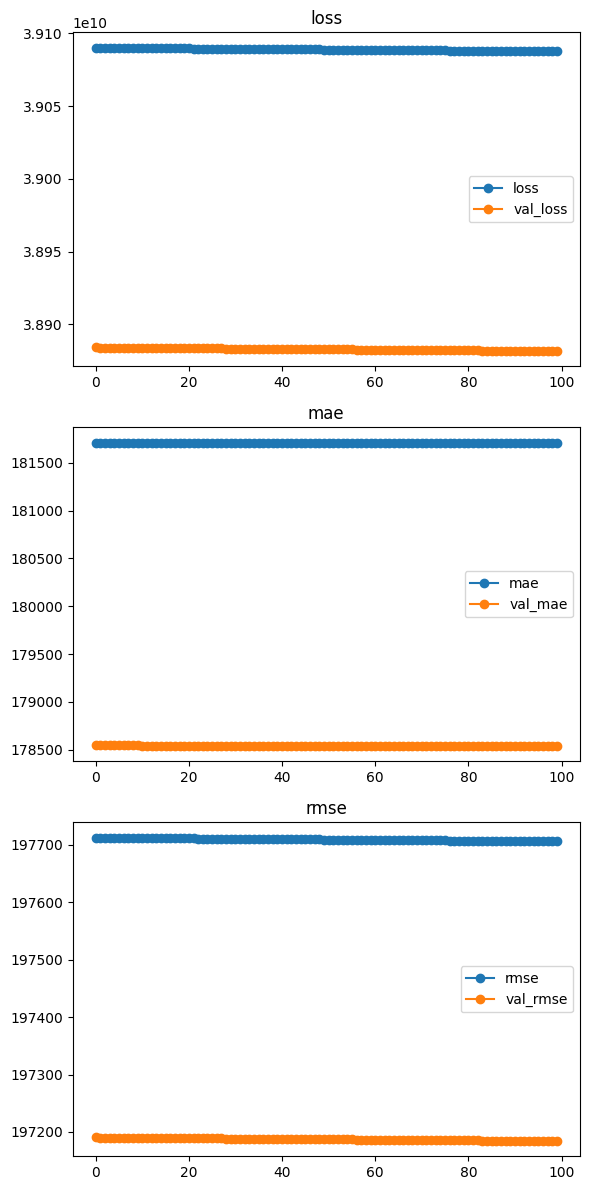

In [117]:
# Apply the custom function to see how your model is doing
plot_history(history)

In [122]:
# Evalution
train_scores = eval_regression(model1,
                         X_train_processed,
                         y_train,
                         name='model1 Train')
test_scores = eval_regression(model1,
                                       X_test_processed,
                                       y_test,
                                       name='model1 Test')
scores = pd.concat([train_scores, test_scores])
scores

12/12 [==============================] - 0s 3ms/step


,MAE,RMSE,R2
model1 Train,181703.555243,197705.910680,-5.437945
model1 Test,178539.191785,197184.056287,-4.550298


- Based on these results, Model 1 appears to be performing poorly.
- The negative R2 indicates that the model's predictions are not explaining the variance in housing prices, and both MAE and RMSE are relatively high, indicating a lack of accuracy in predictions.

# Model 2: More Neurons

In [124]:
# Reset Random seed for consistency
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

# use all features as input using input_dim
input_dim = X_train_processed.shape[1]

# Instantiate your sequential model
model2 = Sequential()

# Add hidden layer
model2.add(Dense(3, activation= 'relu', input_dim = input_dim, name ='h1'))
model2.add(Dense(6, activation='relu', name='h2'))
model2.add(Dense(10, activation='relu', name='h3'))

# Add output layer with 1 node
model2.add(Dense(1, activation = 'linear', name = 'output'))

# Check summary of network
model2.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 h1 (Dense)                  (None, 3)                 903       
                                                                 
 h2 (Dense)                  (None, 6)                 24        
                                                                 
 h3 (Dense)                  (None, 10)                70        
                                                                 
 output (Dense)              (None, 1)                 11        
                                                                 
Total params: 1008 (3.94 KB)
Trainable params: 1008 (3.94 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [126]:
# Fit your model
history = model2.fit(X_train_processed, y_train,
                        validation_data = (X_test_processed, y_test),
                        epochs = 100, verbose=False)

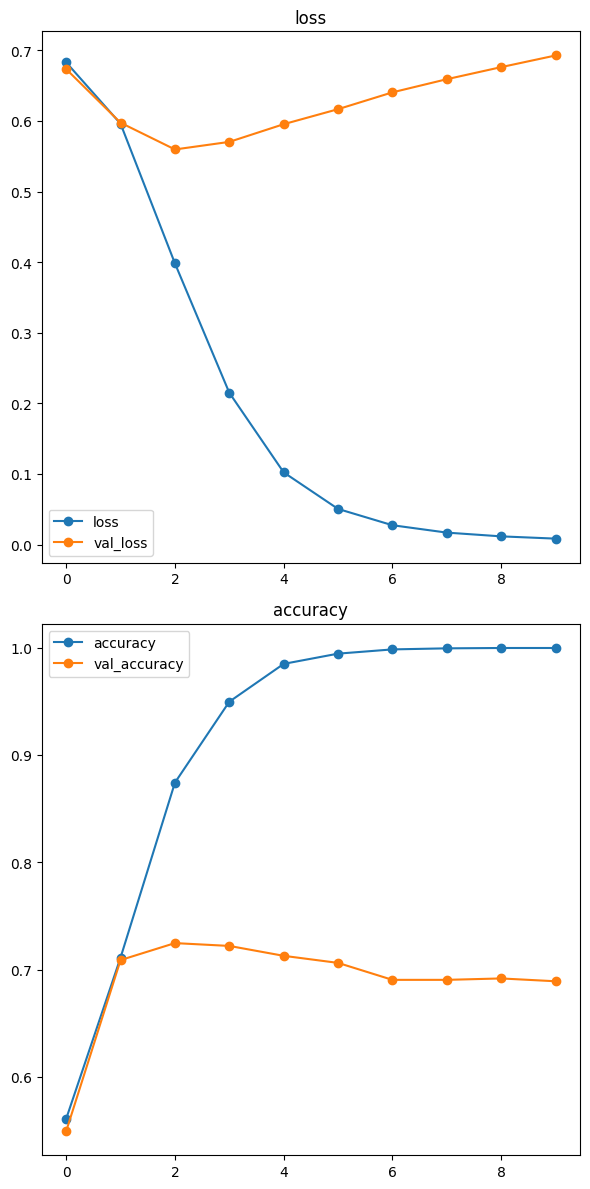

In [28]:
# Apply the custom function to see how your model is doing
plot_history(history)

In [127]:
#Evalution
train_scores = eval_regression(model2,
                         X_train_processed,
                         y_train,
                         name='model2 Train')
test_scores = eval_regression(model2,
                                       X_test_processed,
                                       y_test,
                                       name='model2 Test')
scores = pd.concat([scores, train_scores, test_scores])
scores

12/12 [==============================] - 0s 3ms/step


,MAE,RMSE,R2
model1 Train,181703.555243,197705.910680,-5.437945
model1 Test,178539.191785,197184.056287,-4.550298
model2 Train,22801.090494,37510.075143,0.768259
model2 Test,22825.982277,38629.531490,0.786984


 - Model 2 appears to be performing much better than Model 1.
 - The positive R2 values indicate that the model's predictions are explaining a significant portion of the variance in housing prices, and both MAE and RMSE are relatively low, indicating greater accuracy in predictions.

# Model 3: More layers

In [128]:
# Instantiate your sequential model
model3 = Sequential()

# Add hidden layers
model3.add(Dense(100, activation= 'relu', input_dim = input_dim, name ='h1'))
model3.add(Dense(60, activation='relu', name='h2'))
model3.add(Dense(100, activation='relu', name='h3'))
model3.add(Dense(10, activation='relu', name='h4'))
model3.add(Dense(10, activation='relu', name='h5'))

# Add output layer with 1 node
model3.add(Dense(1, activation='linear', name ='output'))

# Check summary of network
model3.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 h1 (Dense)                  (None, 100)               30100     
                                                                 
 h2 (Dense)                  (None, 60)                6060      
                                                                 
 h3 (Dense)                  (None, 100)               6100      
                                                                 
 h4 (Dense)                  (None, 10)                1010      
                                                                 
 h5 (Dense)                  (None, 10)                110       
                                                                 
 output (Dense)              (None, 1)                 11        
                                                                 
Total params: 43391 (169.50 KB)
Trainable params: 4339

In [129]:
# Compile your model.
rmse = RootMeanSquaredError(name='rmse')
model3.compile(optimizer= 'adam', loss = 'mse', metrics= ['mae', rmse])

(<Figure size 600x1200 with 3 Axes>,
 array([<Axes: title={'center': 'loss'}>, <Axes: title={'center': 'mae'}>,
        <Axes: title={'center': 'rmse'}>], dtype=object))

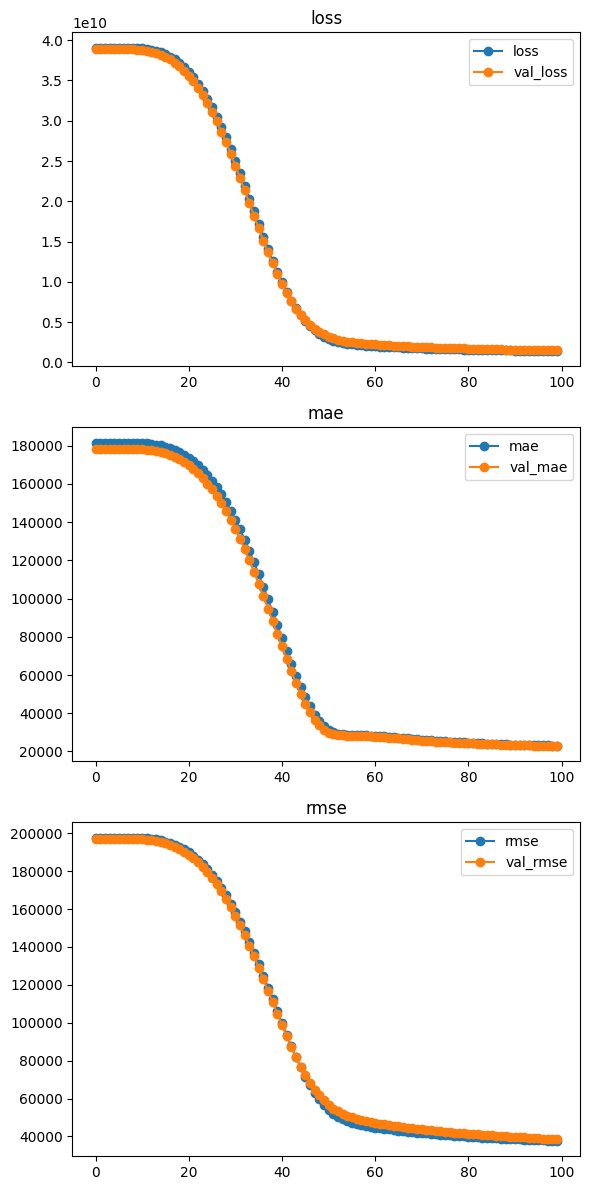

In [130]:
# Apply the custom function to see how your model is doing
plot_history(history)

In [131]:
train_scores = eval_regression(model3,
                         X_train_processed,
                         y_train,
                         name='model3 Train')
test_scores = eval_regression(model3,
                                       X_test_processed,
                                       y_test,
                                       name='model3 Test')
scores = pd.concat([scores, train_scores, test_scores])
scores

12/12 [==============================] - 0s 3ms/step


,MAE,RMSE,R2
model1 Train,181703.555243,197705.910680,-5.437945
model1 Test,178539.191785,197184.056287,-4.550298
model2 Train,22801.090494,37510.075143,0.768259
model2 Test,22825.982277,38629.531490,0.786984
model3 Train,181712.386951,197714.031790,-5.438473
model3 Test,178548.022545,197192.058563,-4.550748


 - Model 3 does not perform well compared to Models 1 and 2.
 - The negative R2 values indicate that the model's predictions are not explaining the variance in housing prices and may not be a suitable choice for this task.

### choose your model

Lowest MAE and RMSE:
  - Model 2 has the lowest MAE and RMSE values on both the training and test sets. This indicates that its predictions are closer to the actual housing prices, which is a desirable trait for a regression model.

Positive R2 Value:
  - Model 2 also has positive R2 values on both the training and test sets. While the R2 values are not extremely high, the fact that they are positive suggests that this model explains some of the variance in housing prices. A positive R2 is a crucial indicator for regression models.


Therefore, I recommend choosing Model 2 as the final model for predicting housing prices.